In [1]:
import numpy as np
from typing import List 
from scipy import stats
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
class Bandit:
    def __init__(self, true_mean: float):
        """Gaussian with fixed precision"""
        # Parameters for mu - prior is N(true_mean, tau)
        self.true_mean = true_mean
        self.tau = 1 
        # Parameters for posterior is N(predicted_mean, lmbda)
        self.predicted_mean = 0 
        self.lmbda = 1
        self.sum_x = 0
        self.N = 0

    def pull(self):
        return np.random.randn() / np.sqrt(self.tau) + self.true_mean 
    
    def sample(self):
        return np.random.randn() / np.sqrt(self.lmbda) + self.predicted_mean

    def update(self, x):
        self.lmbda += self.tau
        self.sum_x += x 
        self.predicted_mean = self.tau * self.sum_x / self.lmbda
        self.N += 1

    


In [3]:
# Random Variables 
def setup_normal(mu: float = 0.0, sd: float = 1.0) -> callable:
    def normal_rvs():
        return np.random.normal(mu, sd) 
    return normal_rvs


def setup_exponential(m: float, mu: float = 1.0, sd: float = 1.0) -> callable:
    def exp_rvs():
        return stats.expon(loc=mu, scale=sd) + m
    return exp_rvs


def setup_bernoulli(p: float) -> callable:
    def bern_rvs():
        return stats.bernoulli(p).rvs
    return bern_rvs()

In [6]:
def plot_posterior(bandits: Bandit, samples: int):
    x = np.linspace(-3.0, 6.0, 200)
    line_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    plt.figure(figsize=(15, 8))
    plt.title(f"Posterior After {samples} Samples")
    for i, bandit in enumerate(bandits):
        plt.plot(
            x, stats.norm.pdf(x, bandit.predicted_mean, 1.0 / np.sqrt(bandit.lmbda)), 'r-', lw=3, alpha=0.6,
            label=f'bandit {i}, true mean: {(bandit.true_mean)}, num plays: {bandit.N}', c=line_colors[i]
            ) 
    plt.legend()


In [7]:
def experiment(num_trials: int = 10000, bandit_skews: List[float] = [0.01, 0.2, 0.7], show_plots: bool = False):
    bandits = [Bandit(skew) for skew in bandit_skews]
    n_bandits = len(bandits)
    rewards = np.zeros(num_trials)
    num_times_explored = 0
    num_times_exploited = 0
    num_optimal = 0
    optimal_j = np.argmax(bandit_skews)
    print(f'Optimal bandit: {optimal_j}')

    sample_points = [5, 10, 20, 50, 100, 200, 500, 1000, 1500, 2000]

    for i in range(num_trials):
        # Thompson Sampling 
        samples = [bandit.sample() for bandit in bandits] 
        j = np.argmax(samples)
        if j == optimal_j:
            num_optimal += 1
        # Plot the posterios
        if i in sample_points:
            plot_posterior(bandits, i)

        # Pull the arm for the bandit choosen
        x = bandits[j].pull()
        # Update the rewards log
        rewards[i] = x
        # Update the distribution for the chosen bandit
        bandits[j].update(x)

    # Print the mean estimates for each bandit
    #for i, bandit in enumerate(bandits):
    #    print(f'Mean estimate of bandit {i}: {bandit.:.4f}')
    
    cumulative_rewards = np.cumsum(rewards)
    win_rates = cumulative_rewards / (np.arange(num_trials) + 1)

    if show_plots:
        # Print total reward
        print(f"Total reward earned: {rewards.sum()}")
        print(f"Overall win rate: {rewards.sum() / num_trials}")
        print(f"Num_times_explored: {num_times_explored}")
        print(f"Num_times_exploited: {num_times_exploited}")
        print(f"Num times selected optimal bandit: {num_optimal}")
        print("Num times selected each bandit:", [b.N for b in bandits]) 
        
        # plot the results
        plt.figure(figsize=(15, 8))
        plt.title("Win Rate Over Time (x-axis log scale)")
        plt.plot(win_rates)
        for skew in bandit_skews:
            plt.plot(np.ones(num_trials) * skew)
        plt.plot(np.ones(num_trials) * np.max(bandit_skews))
        plt.xscale('log')
        plt.show()
    return win_rates

Optimal bandit: 2
Total reward earned: 6944.256817032514
Overall win rate: 0.6944256817032514
Num_times_explored: 0
Num_times_exploited: 0
Num times selected optimal bandit: 9944
Num times selected each bandit: [11, 45, 9944]


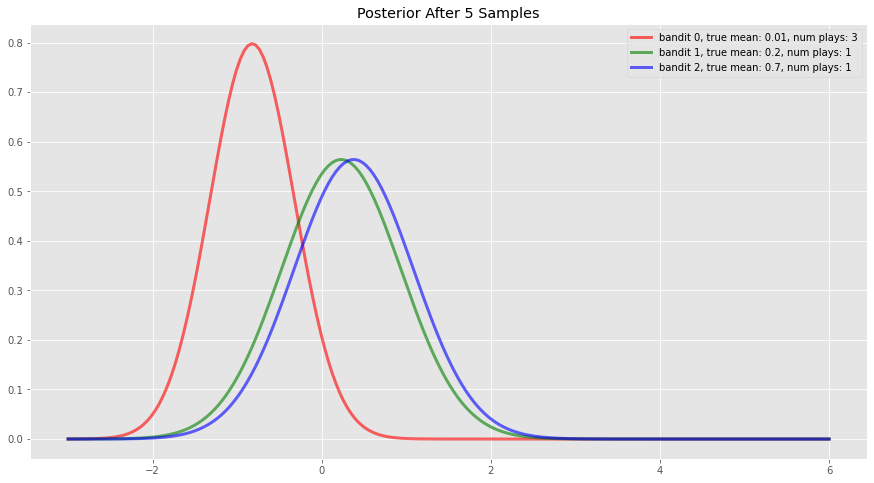

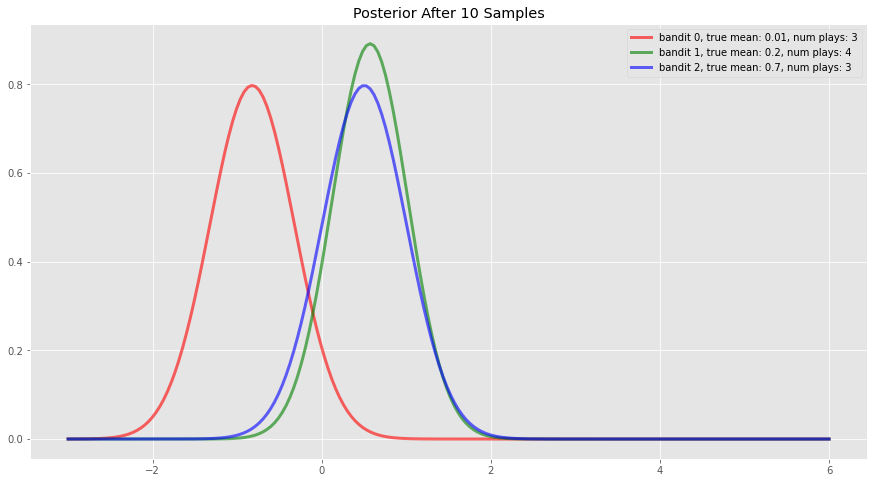

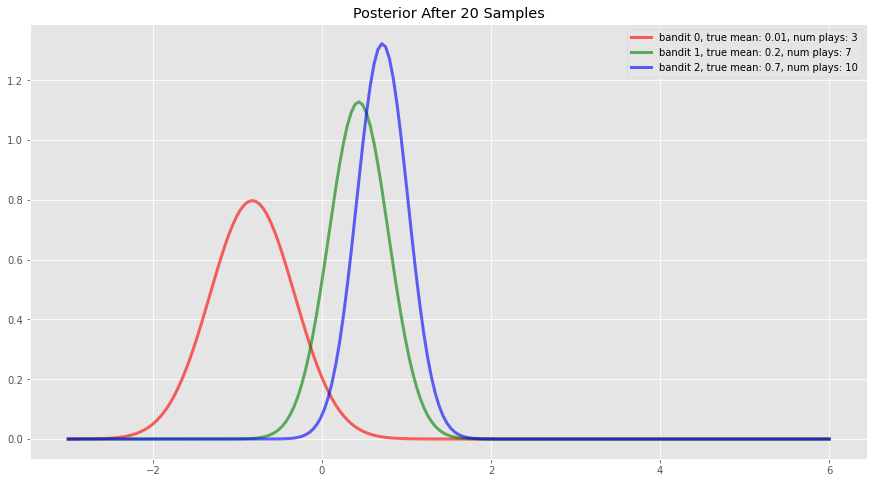

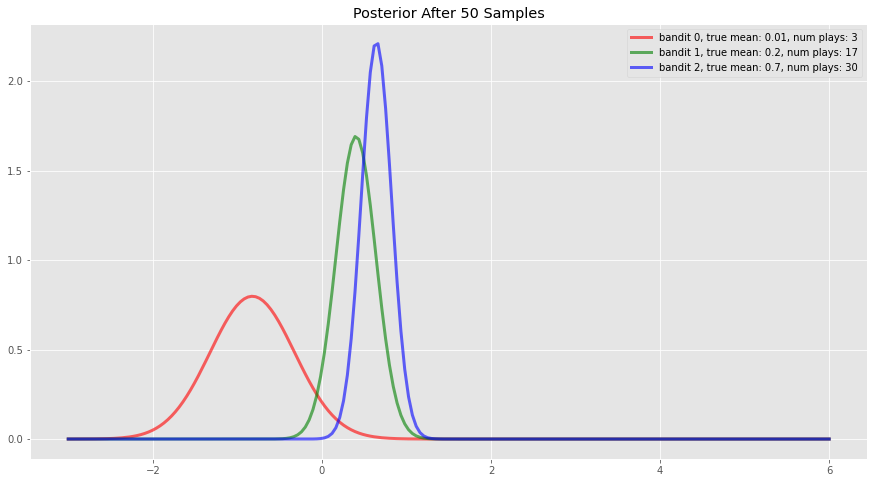

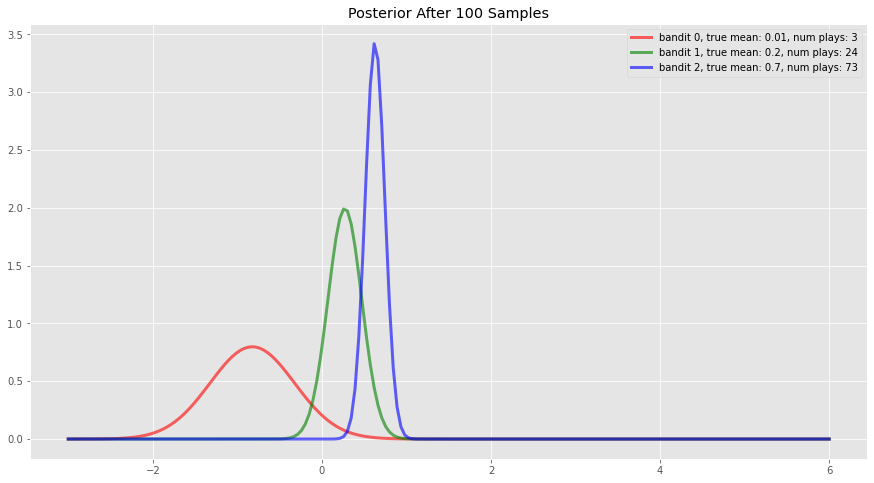

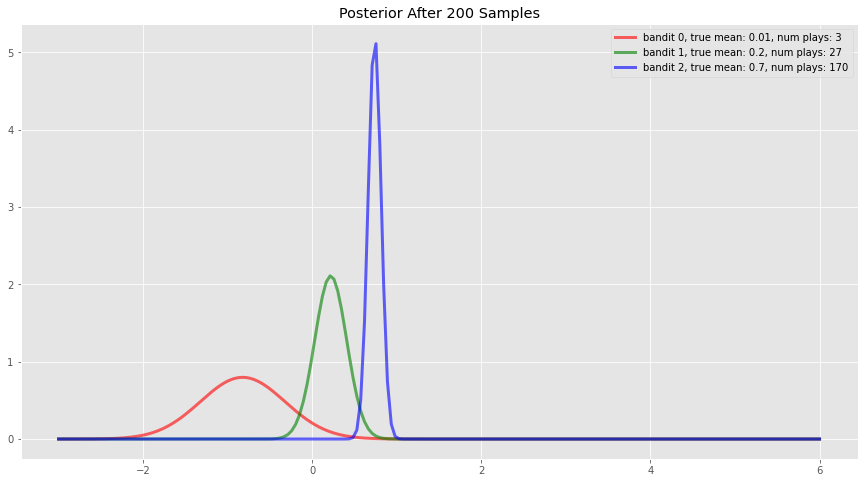

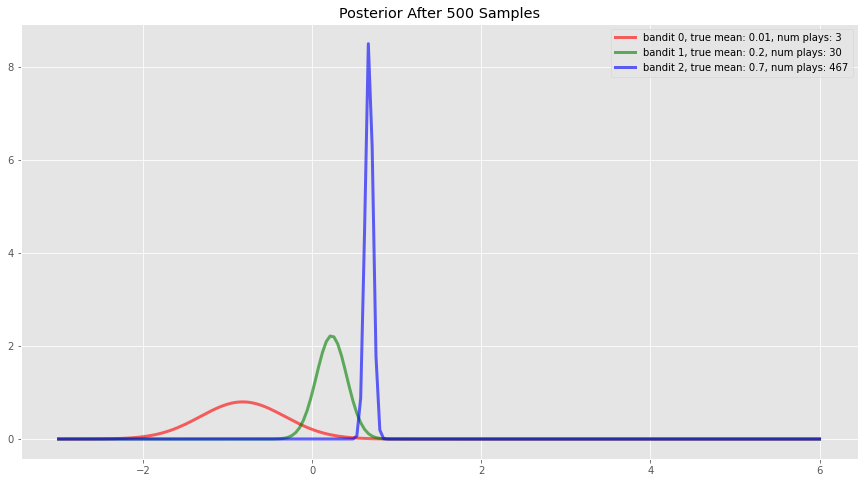

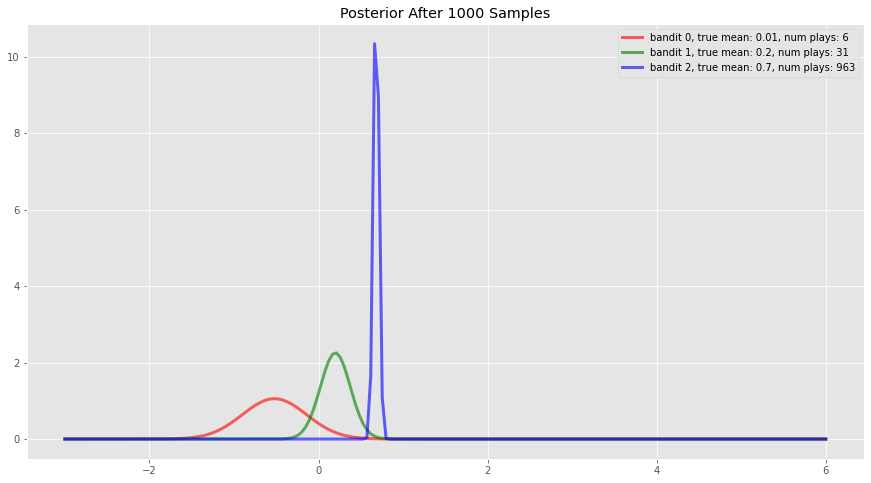

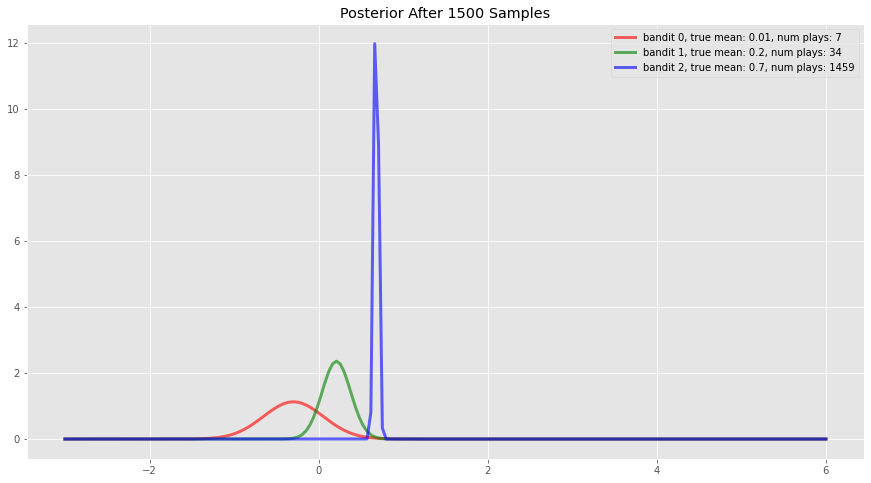

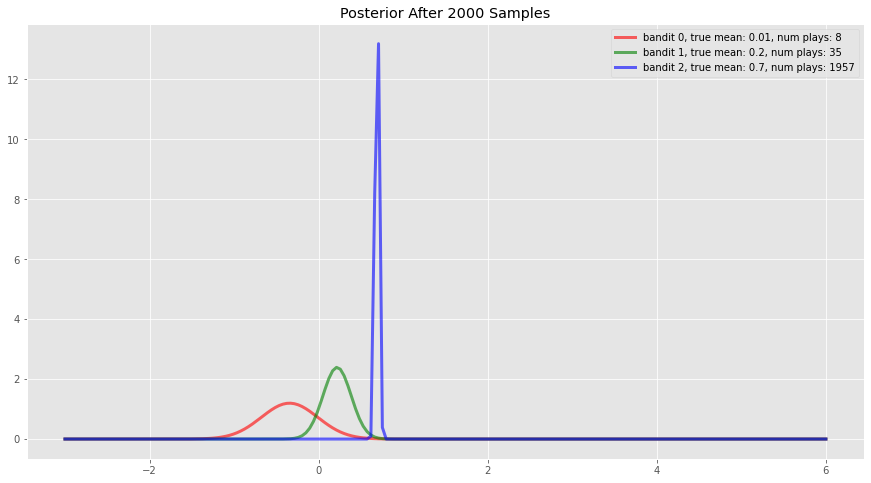

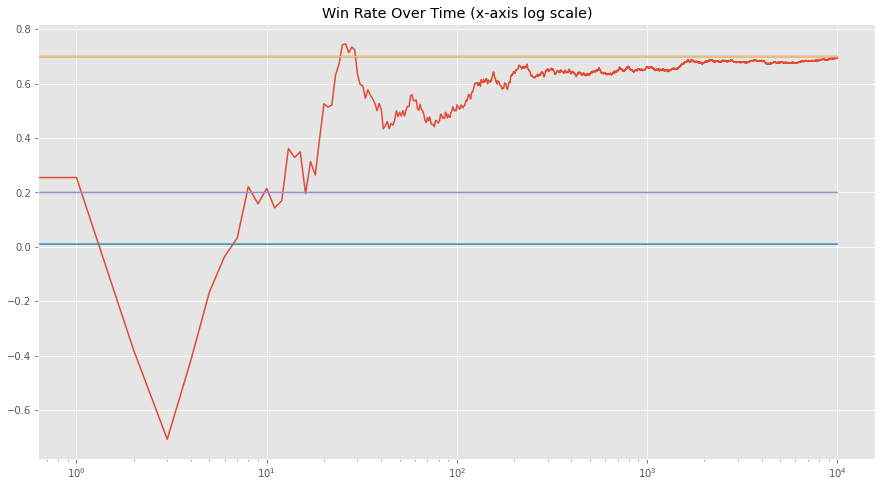

array([ 0.05057761,  0.25493678, -0.38134784, ...,  0.69448987,
        0.69428067,  0.69442568])

In [9]:
experiment(show_plots=True)
